In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 5. 서포트 벡터 머신

서포트 벡터 머신(SVM)
- 강력하고 선형이나 비선형 분류, 회귀, 이상치 탐색에도 사용할 수 있는 다목적 머신러닝 모델  
- 복잡한 분류 문제에 잘 들어맞으며 작거나 중간 크기의 데이터셋에 적합

## 5.1 선형 SVM 분류

SVM 분류기를 클래스 사이에 가장 폭이 넓은 도로를 찾는 것으로 생각할 수 있어 라지 마진 분류(large margin classification)라고도 한다.

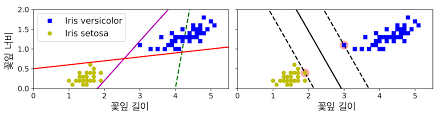

결정 경계는 도로 경계에 위치한 샘플에 의해 전적으로 결정된다. 이 샘플을 서포트 벡터라고 한다.

++ 특성 스케일을 조정하면 결정경계가 훨씬 좋아진다.

### 5.1.1 소프트 마진 분류

하드 마진 분류  
- 모든 샘플이 도로 바깥쪽에 올바르게 분류되도록 하는 마진 분류
- 훈련세트가 선형적으로 구분되는 경우에만 가능

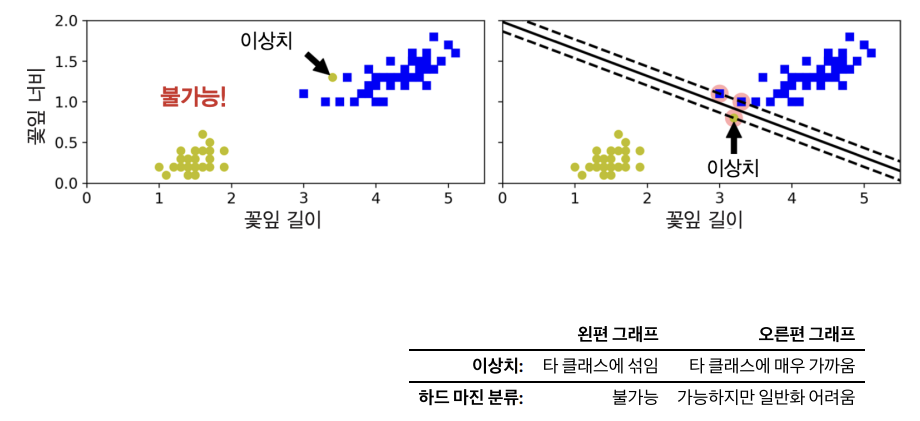

소프트 마진 분류
- 마진 오류(margin violation) 사례의 발생 정도를 조절하면서 도로의 폭을 최대로 넓게 유지하는 마진 분류
- 마진 오류 : 샘플이 도로 중간이나 반대쪽에 있는 경우

사이킷런의 SVM 모델에서 하이퍼파라미터 C를 조절하여 마진 오류를 해결할 수 있다.  
C가 작은 경우, 마진 오류가 다수 포함되고, 도로의 폭이 넓게 형성되며,  
C가 큰 경우, 마진 오류는 적어지고 도로의 폭이 좁아진다.

과대적합인 경우에는 C를 감소시켜 규제할 수 있다.

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2,3)]
y= (iris["target"] == 2).astype(np.float64)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge")),
])

svm_clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [3]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

SGDClassifier로 선형 SVM 분류기 훈련하는 방법
- 표현법 : SGDClassifier(loss="hinge", alpha=1/(m * C))
- 데이터셋이 커 외부 메모리를 사용해야 하거나, 온라인 학습으로 분류 문제를 다룰때 유용


## 5.2 비선형 SVM 분류

선형적으로 분류할 수 없는 데이터셋의 경우는 다항 특성과 같은 특성을 더 추가하여 구분할 수 있다.

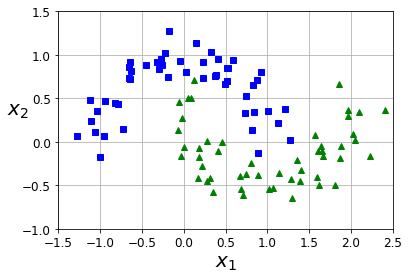

In [4]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [5]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X,y)

C:\Users\youth_0619\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

그림 저장: moons_polynomial_svc_plot


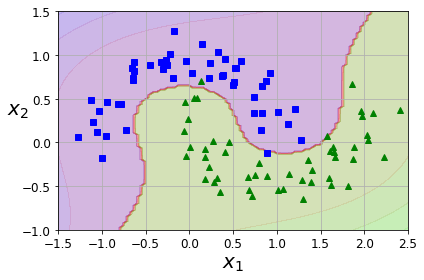

In [6]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    # np.linspace : 함수 그릴때 촘촘하게 그리는 방법
    # np.linspace(시작점, 끝점, 구간내 숫자 개수)
    x0, x1 = np.meshgrid(x0s, x1s) # grid
    X = np.c_[x0.ravel(), x1.ravel()] # ravel() : 1차원으로 변환
    # np.c_ : column으로 변경하고 가로로 붙여 n*2 행렬 형성
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2) # alpha : 투명도 조정
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

### 5.2.1 다항식 커널

SVM 사용시 커널 트릭을 사용할 수 있다.  

<커널 트릭>  
* 실제로는 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과를 얻을 수 있다.
* 특성조합이 생기지 않음

In [7]:
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

* SVC의 coef0
    * coef0 : 다항식 커널의 상수항
    * 다항식 커널은 차수가 높아질수록 1보다 작은 값과 큰 값의 차이가 커지므로 coef0을 적절하게 지정하면 고차항의 영향을 줄일 수 있음.

In [8]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

그림 저장: moons_kernelized_polynomial_svc_plot


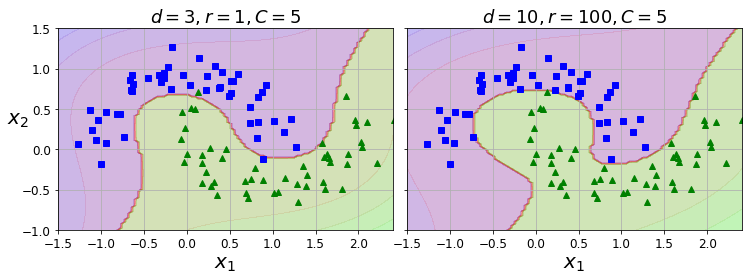

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

### 5.2.2 유사도 특성
각 샘플이 특정 랜드마크와 얼마나 닮았는지 측정하는 "유사도 함수"로 계산한 특성을 추가하여 비선형 특성을 다룰 수 있다.

가우시안 방사 기저 함수


그림 저장: kernel_method_plot


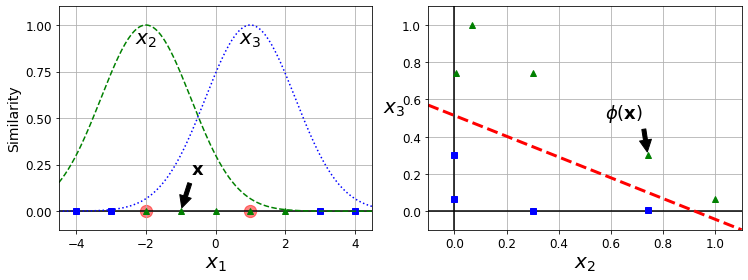

In [10]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)

def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

In [11]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


데이터셋에 있는 모든 샘플 위치에 랜드마크를 설정하여 선형적으로 분류할 수 있다.  
훈련세트가 매우 클 경우 동일한 크기의 아주 많은 특성이 만들어진다는 단점이 있다.

### 5.2.3 가우시안 RBF 커널
다항 특성 방식처럼 유사도 특성 방식도 커널 트릭을 적용할 수 있다.

In [12]:
rbf_kernel_svm_clf = Pipeline([
    ("sclaer", StandardScaler()),
    ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X,y)

Pipeline(steps=[('sclaer', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

그림 저장: moons_rbf_svc_plot


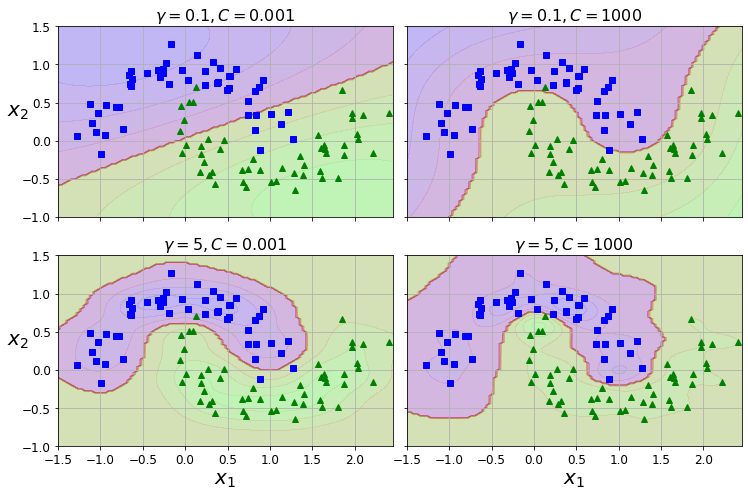

In [13]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

* 커널을 선택하는 방법
1. 선형 커널을 가장 먼저 시도하기(훈련 세트가 아주 크거나 특성 수가 많을때)
2. 가우시안 RBF 커널 시도하기(훈련세트가 너무 크지 않을때)

### 5.2.4 계산 복잡도
1. LinearSVC  
    복잡도는 대략 O(m*n)이다.  
    허용오차 하이퍼파라미터(etha)로 정밀도를 조절하며, 정밀도를 높이면 알고리즘 수행 시간이 길어진다.  
    대부분의 경우 기본값으로 두면 잘 작동한다.
    
2. SVC  
    복잡도는 보통 O(m^2 * n) ~ O(m^3 * n) 사이이다.
    복잡하지만 작거나 중간 규모의 훈련 세트에 이 알고리즘이 잘 맞는다.
    특성의 개수에는 잘 확장되며, 알고리즘의 성능이 샘플이 가진 0이 아닌 특성의 평균 수에 거의 비례한다.


## 5.3 SVM 회귀

SVM을 분류가 아니라 회귀에 적용하는 방법은 목표를 반대로 하는 것이다.  
일정한 마진 오류 안에서 두 클래스 간의 도로 폭이 가능한 한 최대가 되도록 하는 대신, SVM 회귀는 제한된 마진 오류 안에서 도로 안에 가능한 한 많은 샘플이 들어가도록 학습한다.  
도로 폭은 하이퍼파라미터 $ \epsilon $ 로 조절한다.  
마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 옇야이 없기 때문에 이 모델을 $ \epsilon $ -insensitive라고 한다.

1. LinearSVR로 선형 SVM 회귀 적용

In [14]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [15]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [16]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

그림 저장: svm_regression_plot


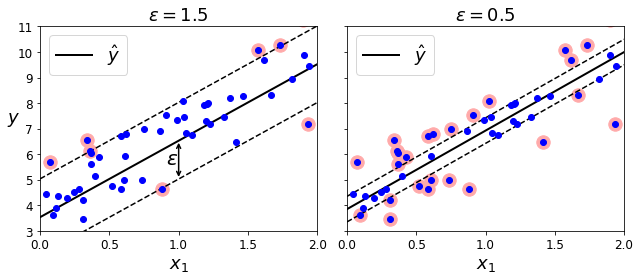

In [17]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

2. 커널 SVM 모델을 사용한 비선형 회귀

In [18]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [19]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

In [20]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

그림 저장: svm_with_polynomial_kernel_plot


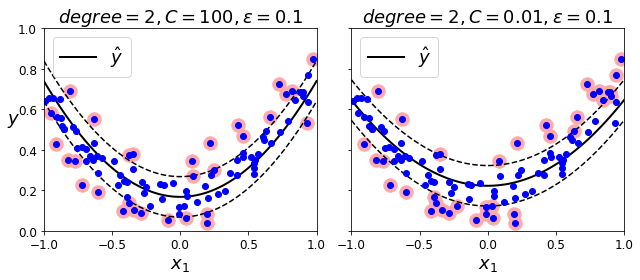

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

LinearSVR은 필요한 시간이 훈련 세트의 크기에 비례해서 선형적으로 늘어나지만,  
SVR은 훈련 세트가 커지면 훨씬 느려진다.

## 5.4 SVM 이론


### 5.4.1 결정함수와 예측

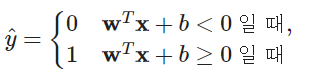

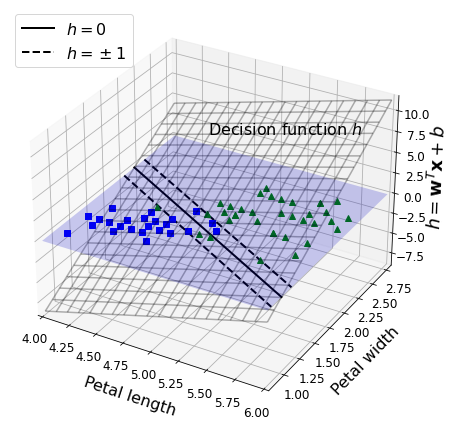

특성이 2개인 데이터셋이므로 2차원 평면이다.  
결정 경계는 결정함수 h의 값이 0인 점들로 이루어진 직선이다.  
-> 일반적으로, n개의 특성이 있을 때 결정 함수는 n차원의 초평면이고 결정경계는 n-1차원의 초평면이다.

점선은 결정함수의 값이 1 또는 -1인 점들로 마진을 형성하고 있다.  
선형 SVM 분류기를 훈련한다는 것은 마진 오류를 하나도 발생하지 않거나 제한적인 마진 오류를 가지면서 가능한 한 마진을 크게 하는 w와 *b*를 찾는 것이다.

### 5.4.2 목적함수

결정함수의 기울기는 가중치 벡터의 norm과 같다.  
가중치 벡터 w가 작을수록 마진은 커진다.

그림 저장: small_w_large_margin_plot


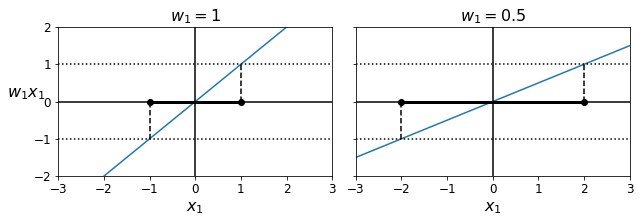

In [24]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

마진을 크게 하기 위해서는 가중치 벡터 w의 norm을 최소화해야 한다.

- 하드 마진 선형 SVM 분류기의 목적 함수

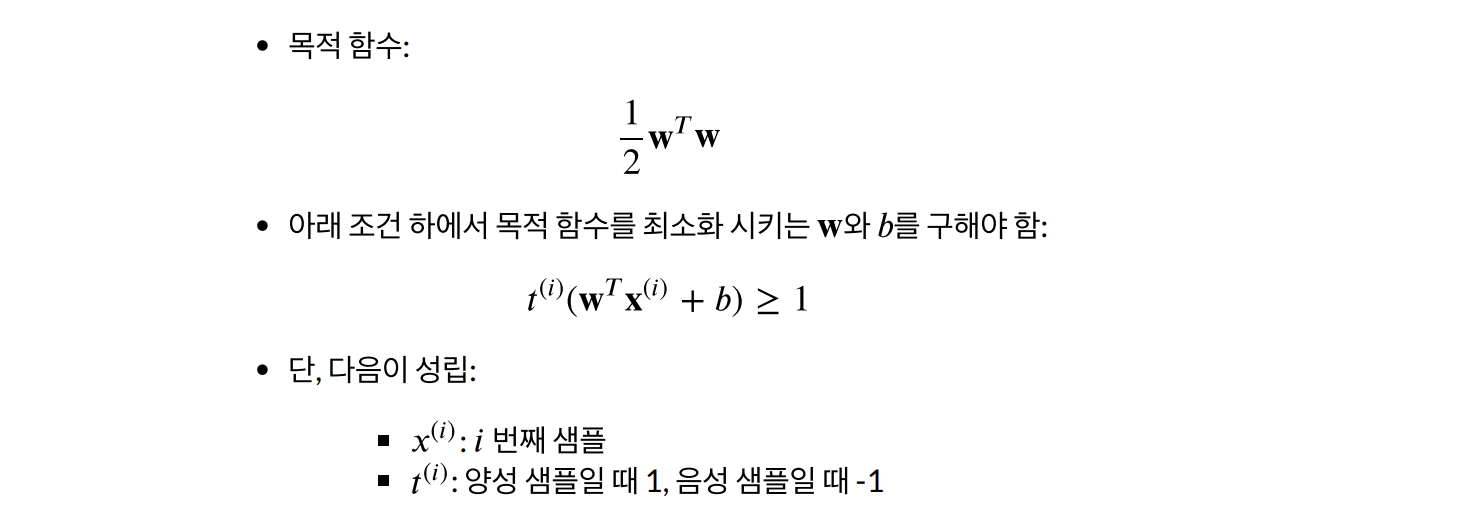

하드마진이므로 결정함수가 모든 양성 훈련 샘플에서는 1보다 커야하고, 음성 훈련 샘플에서는 -1보다 작아야한다.

가중치 벡터 w의 norm은 w=0에서 미분불가능하므로, ${1 \over 2}W^{T}W$를 최소화한다.

* 소프트 마진 선형 SVM 분류기의 목적 함수

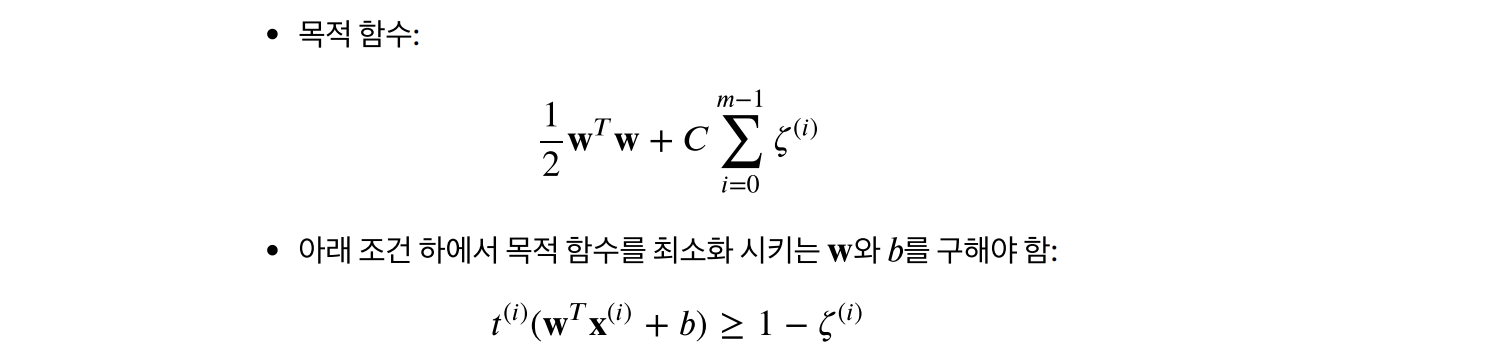

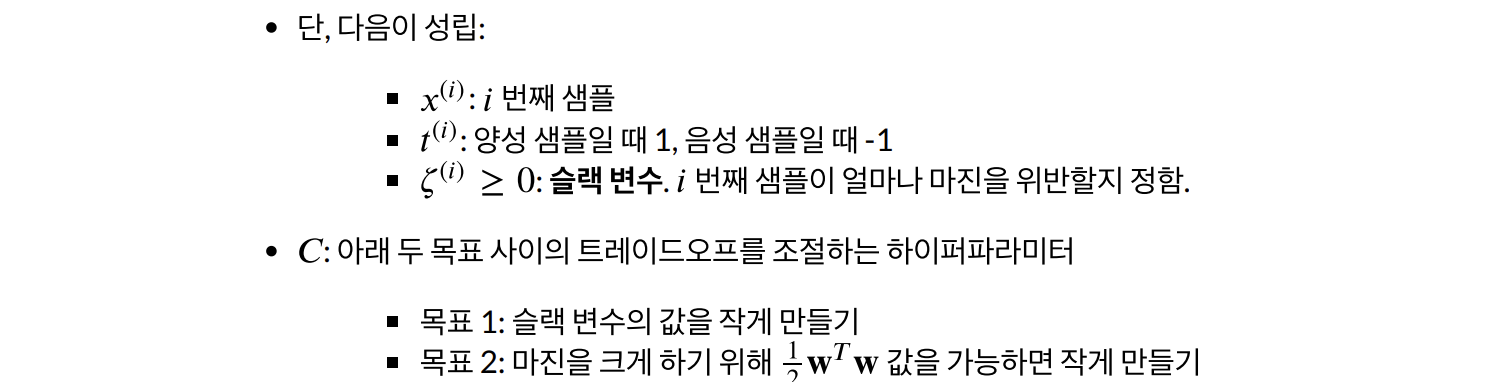

### 5.4.3 콰드라틱 프로그래밍

콰드라틱 프로그래밍
* 선형적인 제약 조건이 있는 볼록함수의 이차 최적화 문제(하드 마진, 소프트마진 문제)

### 5.4.4 쌍대문제

일반적인 쌍대 문제 해는 원 문제 해의 하한값이지만, 어떤 조건하에서는 원 문제와 또같은 해를 제공한다.  
SVM 문제는 원 쌍대 문제의 해가 원 문제의 해와 같은 값으로 도출되므로 둘 중 하나를 선택하여 풀 수 있다.

$$ \frac 1 2 \sum_{i=1}^{m}\sum_{j=1}^{m} \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)}
\mathbf x^{{(i)}^T} \mathbf x^{(j)}-\sum_{i=1}^{m} \alpha^{(i)} $$

$$ 조건 :  i = 1,2, ..., m일때  \alpha^{(i)} >= 0 $$

이 식을 최소화하는 $ \hat{\alpha} $ 를 찾았다면 원 문제의 식을 최소화하는  $ \hat{W} $와  $ \hat{b} $을 계산할 수 있다.

훈련샘플 수가 특성 개수보다 작을 때 원 문제보다 쌍대 문제를 푸는 것이 더 빠르며, 커널 트릭을 가능하게 한다.

### 5.4.5 커널 SVM

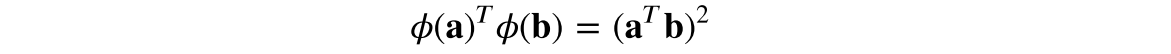

위 식이 성립하기 때문에 앞의 쌍대문제 식을

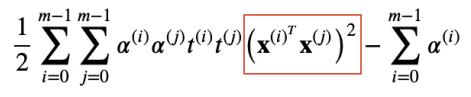

로 변환하여 풀 수 있기 때문에 훈련샘플을 변환할 필요가 전혀 없다.  
이처럼 커널 트릭을 사용하면 전체 과정에 필요한 계산량 측면에서 훨씬 효율적이다.

* 지원되는 커널
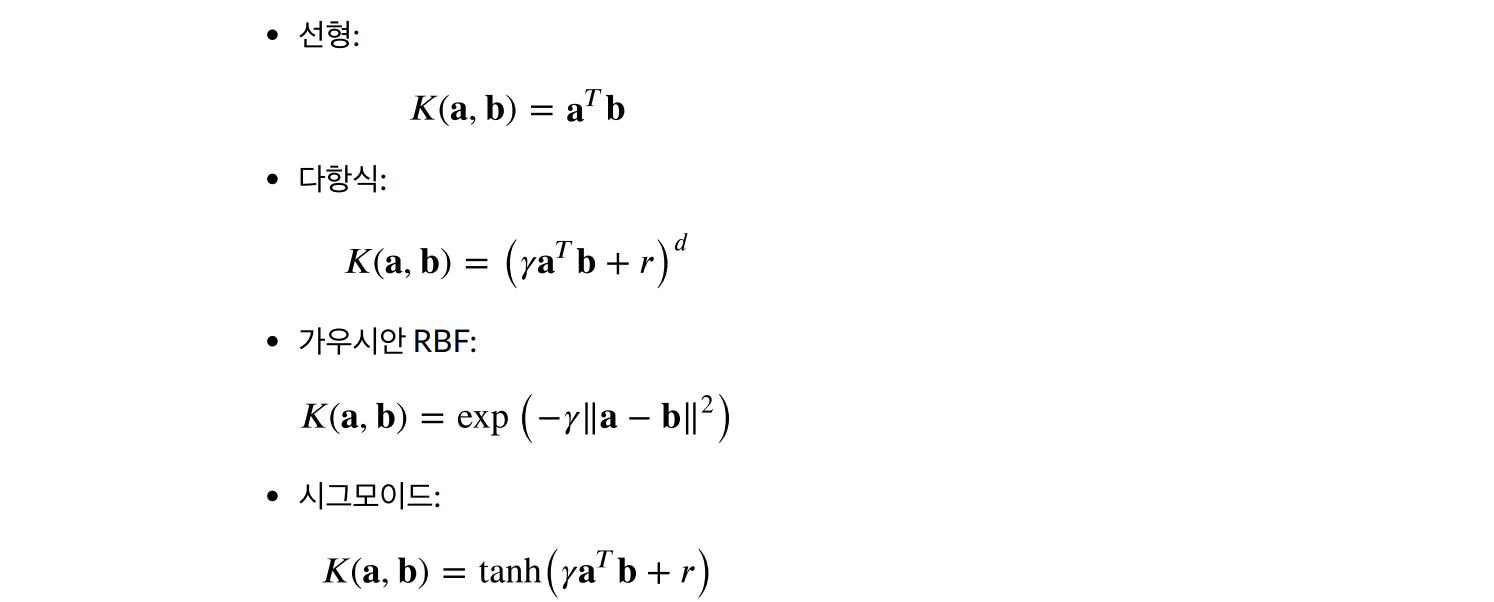

### 5.4.6 온라인 SVM

온라인 SVM 분류기를 구현하는 한 방법은 원 문제로부터 유도된 비용함수를 최소화하기 위한 경사 하강법을 사용하는 것이다. 하지만 경사하강법은 QP 기반의 방법보다 훨씬 느리게 수렴한다.

$$ J(w,b) = \frac 1 2 W^TW + C \sum_{i=1}^{m} max(0,1 -t^{(i)}(W^Tx^{(i)}+b))  $$

이 비용함수의 첫 항은 모델이 작은 가중치벡터를 가지도록 제약을 가해 마진을 크게 만든다.  
두 번째 항은 모든 마진 오류를 계산한다.  
마진오류는 올바른 방향의 도로 경계선까지의 거리에 비례한다.  
이 두 번째 항을 최소화하면 마진 오류를 가능한 한 줄이고 크기도 작게 만든다.